In [5]:
import pandas as pd
import numpy as np
from calcCNV import *
print(anndata.__version__)

0.6.22


In [3]:
chr_pos = pd.read_csv('../data/CNV/hg38_chromPos.csv', index_col=0)
gene_pos = pd.read_csv('../data/CNV/geneinfo.csv')

CNVDict = pickle.load(open('../data/CNV/final.CNVDict.pkl','rb')) # grep selected arms of CNV clustering
CellDict = pickle.load(open("../data/CNV/Cell_CNV_AdataDict.pkl",'rb')) # grep CNV and RNA subcluster labels

In [6]:
# CNV related genes
cnv_gene_dict = {}

for cell,val in CNVDict.items():
    if 'ArmCtsMulti' in val.keys():
        multiModel_cnv = CNVDict[cell]['ArmCtsMulti'] # cells X arms
        cts = CNVDict[cell]['WindowCts'] # cell X genes
        
        for n,arm in enumerate(multiModel_cnv.columns):

            genes = gene_pos[gene_pos['arm']==arm]['symbol'].values
            genes_s = pd.Series([g for g in genes if g in cts.columns], index=[arm]*len([g for g in genes if g in cts.columns]))
            
            cnv_genes = genes_s if n==0 else cnv_genes.append(genes_s)
            print(cell, arm, len(cnv_genes), 'genes...')
        
        cnv_gene_dict[cell] = cnv_genes

MCF7 7p 531 genes...
MCF7 20p 852 genes...
T47D WT 5p 343 genes...
T47D WT 5q 1623 genes...
T47D WT 14q 2993 genes...
T47D WT 15q 4106 genes...
T47D WT 16q 4808 genes...
SUM44 10p 297 genes...
SUM44 17p 852 genes...
MCF10A 7q 970 genes...
MCF10A 14q 2340 genes...
MCF10A 17q 3647 genes...
MCF10A Xq 4269 genes...
HEK293 2q 1295 genes...
HEK293 8p 1766 genes...


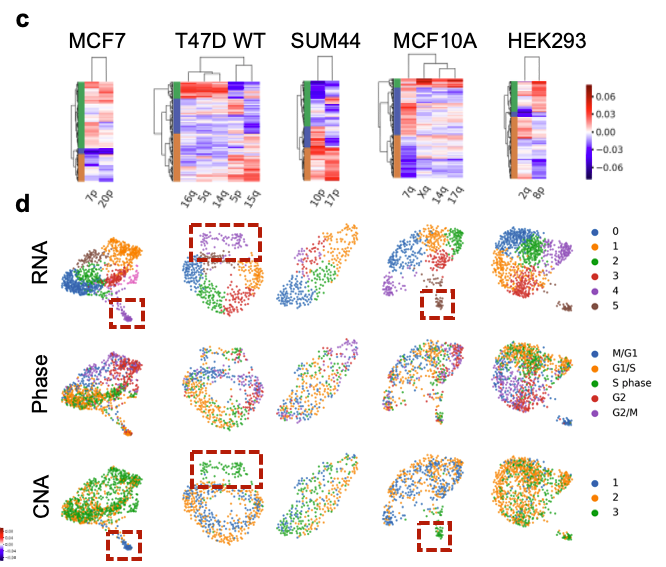


In [15]:
adata_ref_raw = sc.read('../data/scVelo/AL1_ref_raw.h5ad') 

In [12]:
CellDict['MCF7']

AnnData object with n_obs × n_vars = 977 × 5000 
    obs: 'Clusters', '_X', '_Y', 'doublet_bln', 'doublet_score', 'percent_mito', 'n_counts', 'n_genes', 'initial_size_spliced', 'initial_size_unspliced', 'initial_size', 'louvain', 'CellType', 'phase', 'G2', 'M/G1', 'G1/S', 'G2/M', 'S phase', 'CNV_cluster'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'means', 'dispersions', 'dispersions_norm'
    uns: 'pca', 'neighbors', 'louvain', 'draw_graph'
    obsm: 'X_pca', 'X_draw_graph_fa'
    varm: 'PCs'
    layers: 'ambiguous', 'matrix', 'spliced', 'unspliced', 'Ms', 'Mu'

In [35]:
cnv_adata_dict = {}

for cell,val in cnv_gene_dict.items():
    
        
    genes = val.values # genes from corresponding chromosome arms
    labels = CellDict[cell].obs.loc[:,['CellType','louvain','phase','CNV_cluster']]
    
    tmp_raw = adata_ref_raw.copy()
    tmp_raw.obs = tmp_raw.obs.join(labels)
    tmp_raw = tmp_raw[tmp_raw.obs['CellType']==cell][:,genes]  
        
    tmp = tmp_raw.copy()
    ### Normalization
    scv.pp.normalize_per_cell(tmp, layers=['spliced', 'unspliced']) # 3 layers all been normalized by / cts
    scv.pp.log1p(tmp) # only tmp.X is log1p (loge(x+1))
    scv.pp.moments(tmp, n_pcs=30, n_neighbors=30, mode='connectivities', method='umap', use_rep=None)
    
    sc.tl.umap(tmp)
    
    cnv_adata_dict[cell] = tmp

Normalized count data: X, spliced, unspliced.
computing neighbors
    finished (0:00:00) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of spliced/unspliced abundances (adata.layers)
Normalized count data: X, spliced, unspliced.
computing neighbors
    finished (0:00:00) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of spliced/unspliced abundances (adata.layers)
Normalized count data: X, spliced, unspliced.
computing neighbors
    finished (0:00:00) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
computing moments based on connectivities
    finished (0:00:

MCF7


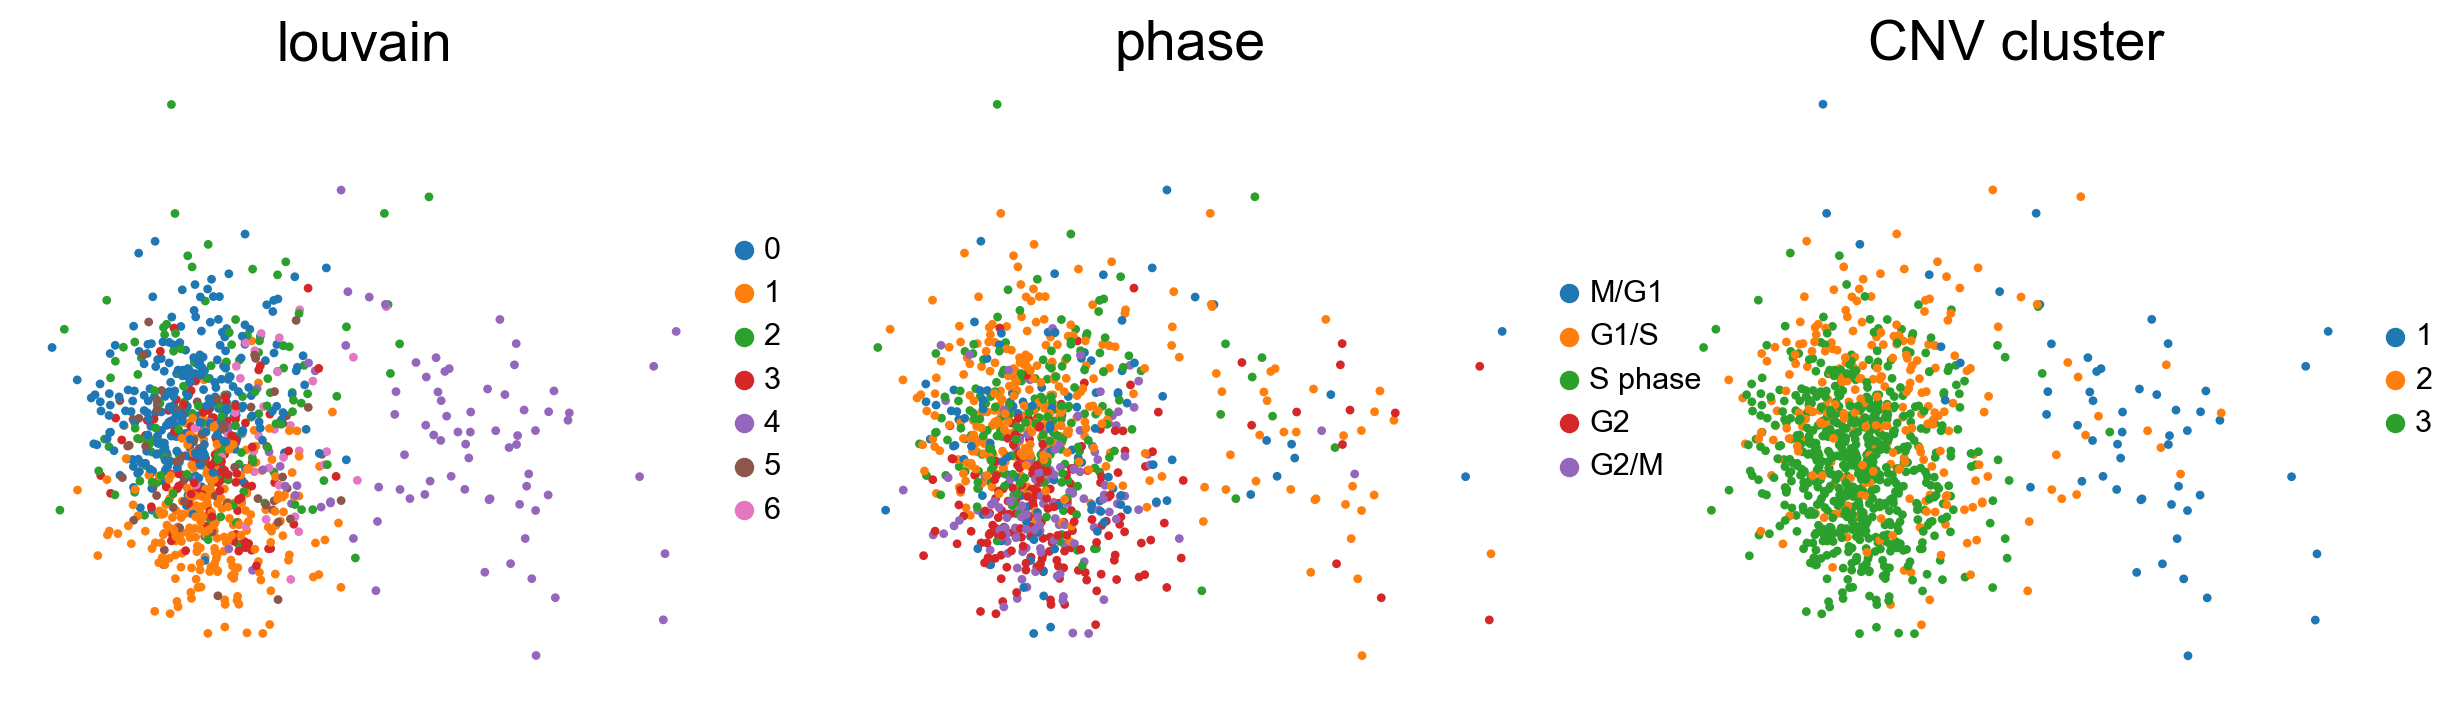

T47D WT


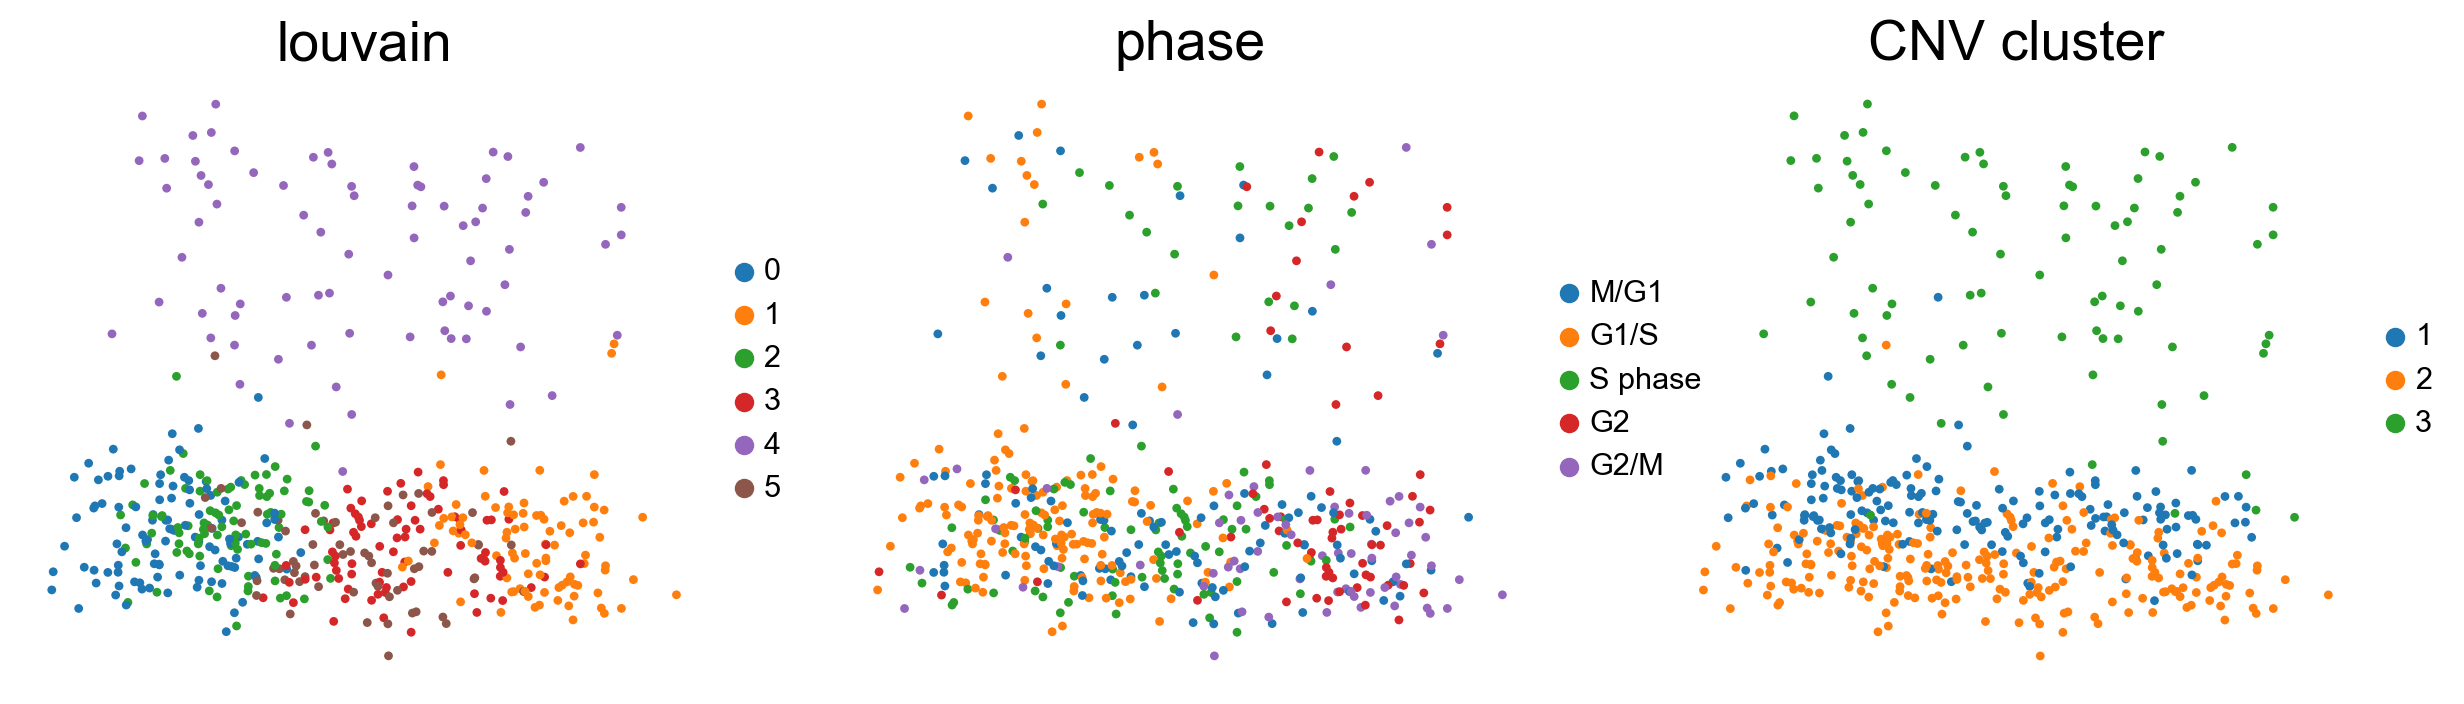

SUM44


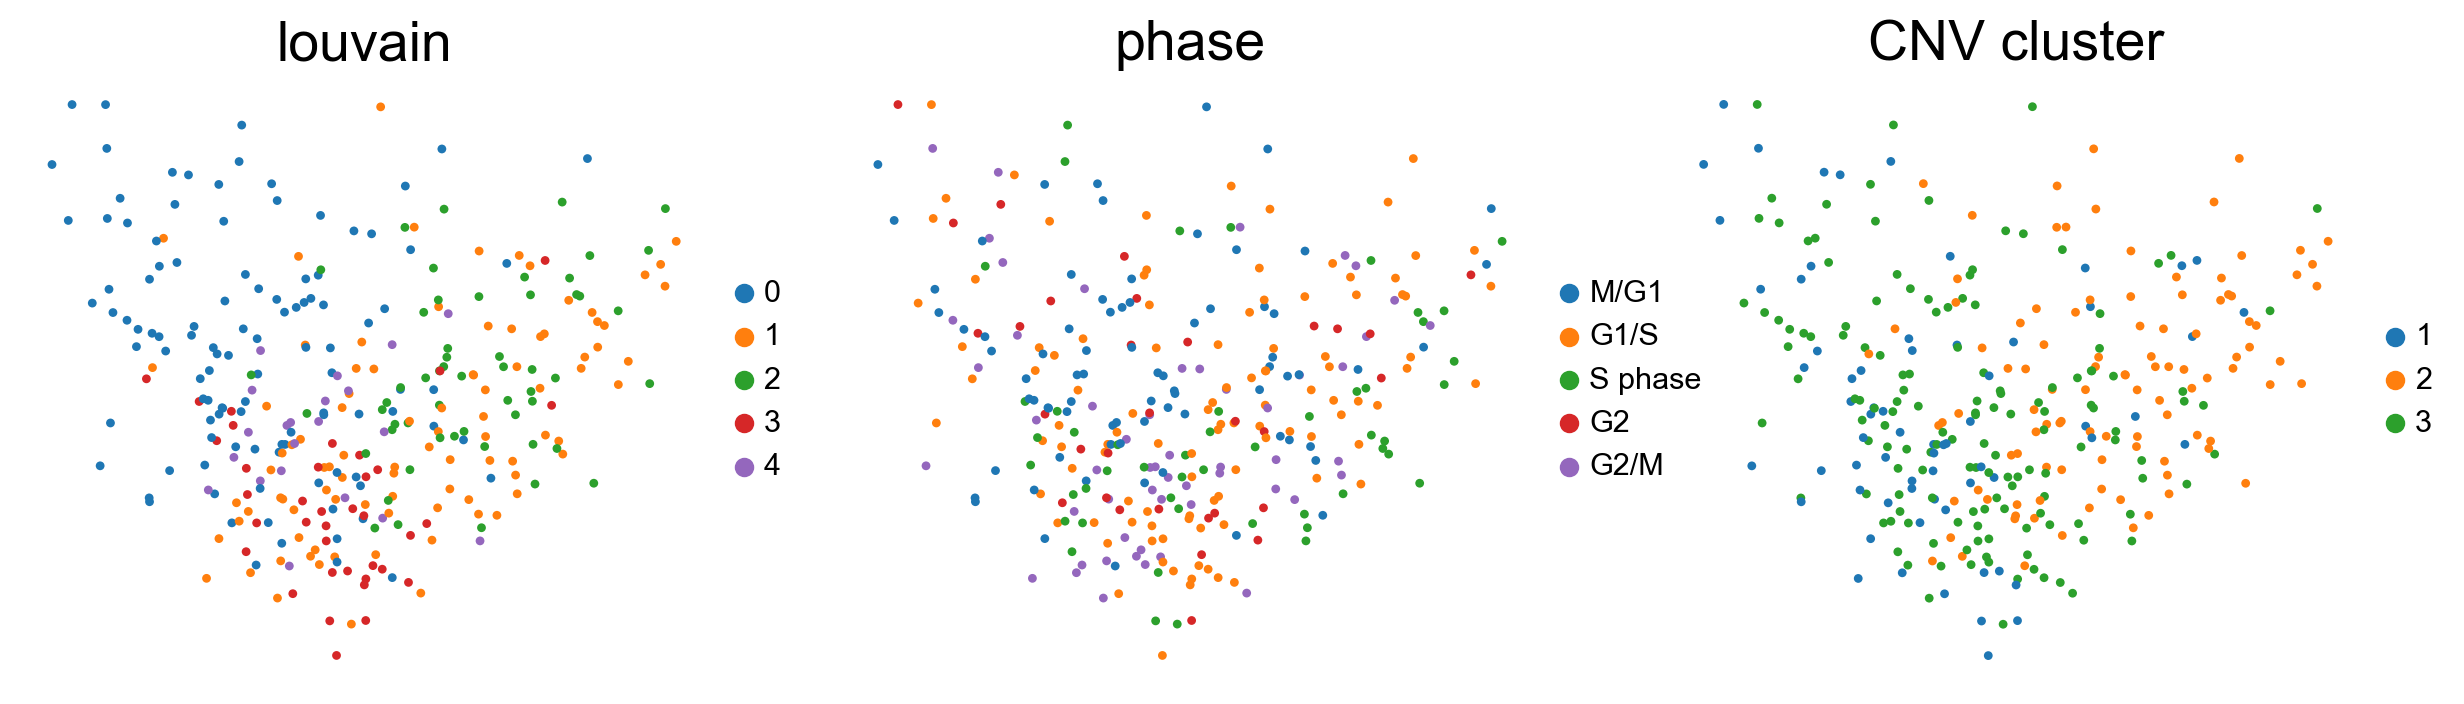

MCF10A


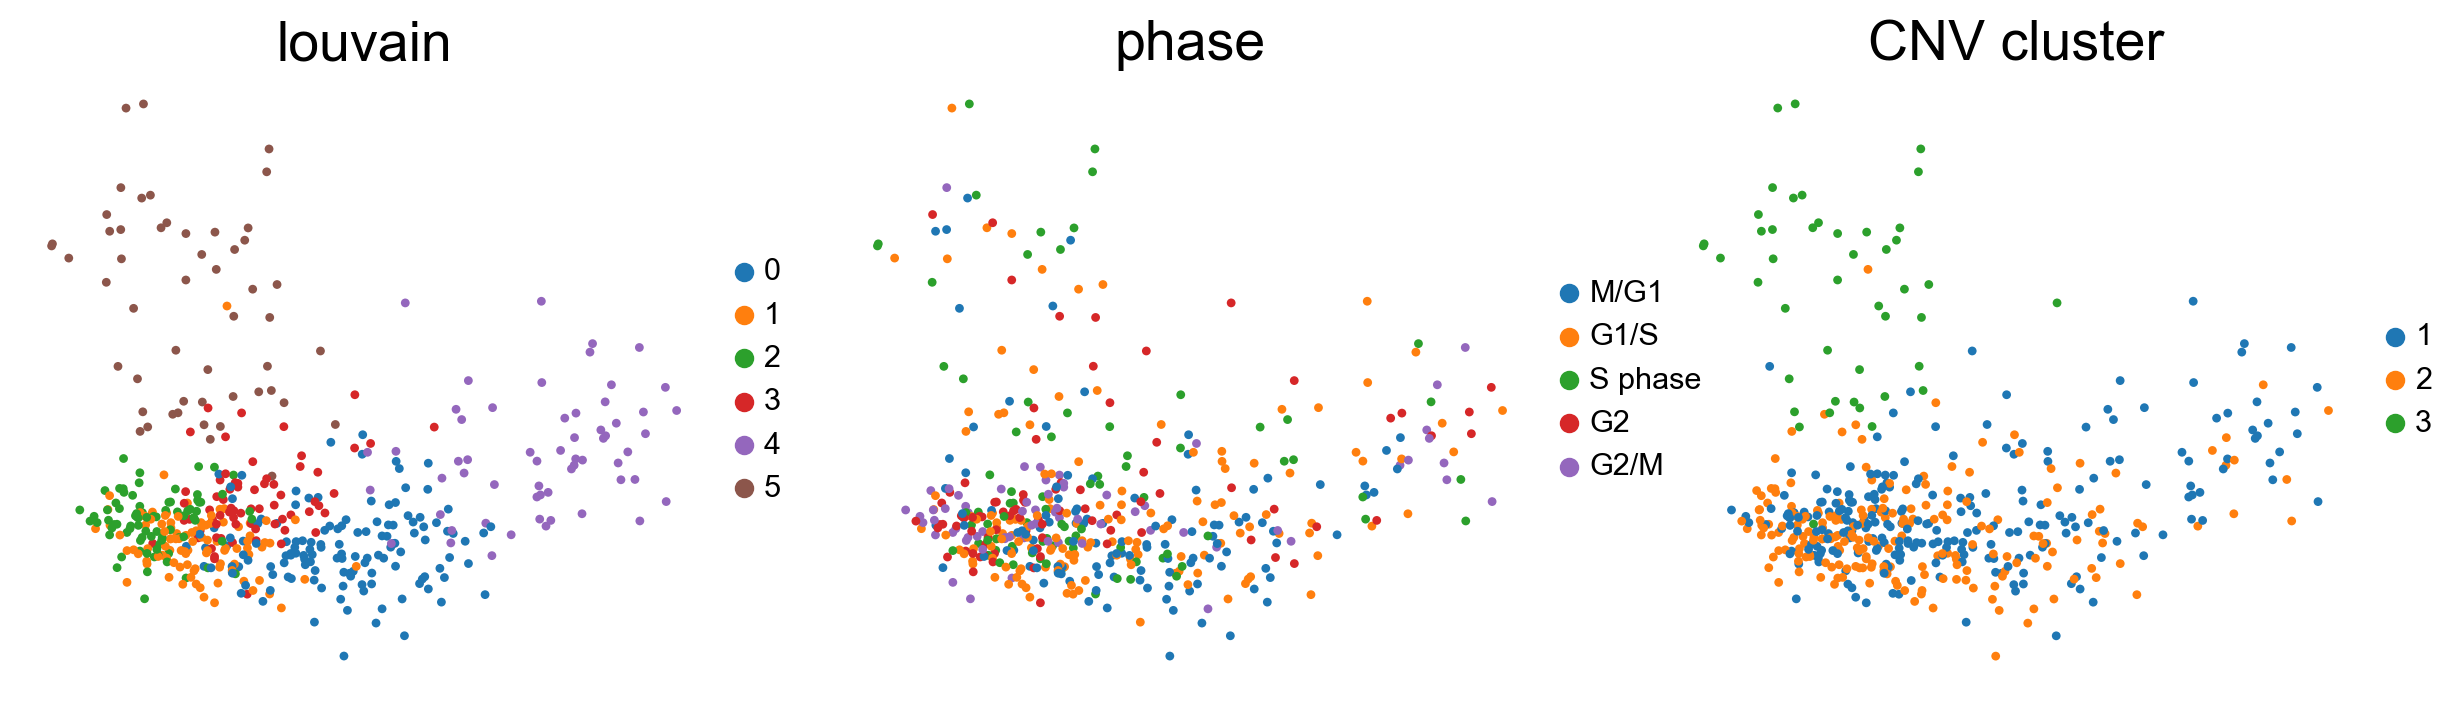

HEK293


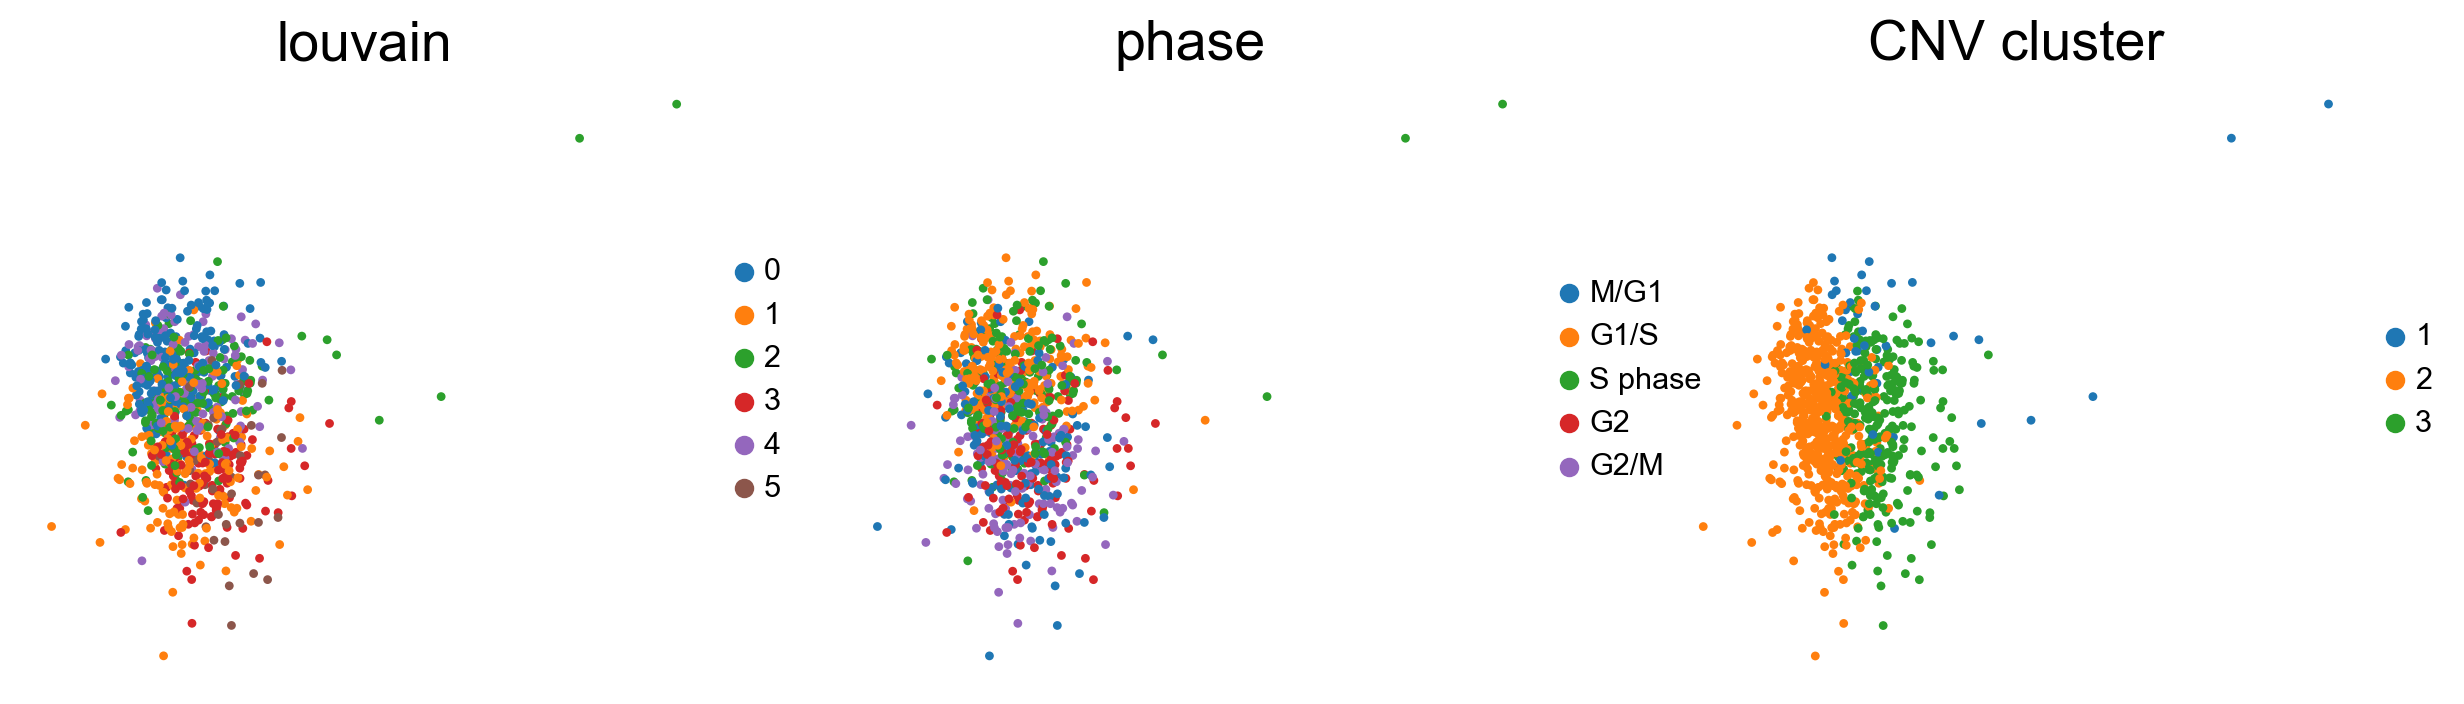

In [36]:
# only use the genes in CNV abberrant chromosome arms to plot RNA expression
# if CNV subclusters are still identifiable, it indicates the abberrant CNAs suffice to distinguish transcriptomics
scv.settings.set_figure_params('scvelo')
for cell,tmp in cnv_adata_dict.items():
    
    print(cell)
    scv.pl.scatter(tmp, color=['louvain','phase','CNV_cluster'], 
               legend_loc='right margin', basis='pca', 
               figsize=(5,4), size=40, dpi=100, fontsize=20)
    

In [37]:
fname = 'rebuttal.figure3.cnv_rna_adata_dict.pkl'
f = open(f"../data/CNV/{fname}.pkl","wb")
pickle.dump(cnv_adata_dict,f)
f.close()